# <center> <img src="figs/LogoUFSCar.jpg" alt="Logo UFScar" width="110" align="left"/>  <br/> <center>Universidade Federal de São Carlos (UFSCar)<br/><font size="4"> Departamento de Computação, campus Sorocaba</center></font>
</p>

<font size="4"><center><b>Disciplina: Aprendizado de Máquina</b></center></font>
  
<font size="3"><center>Prof. Dr. Tiago A. Almeida</center></font>

## <center>Projeto Final</center>

**Nome**: Gabriel Araujo Streicher

**RA**: 822485


In [1]:
## Carregar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.preprocessamento import *
from scripts.analise_exploratoria import *
from scripts.experimentos import *
from scripts.analise_resultados import *
import os
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, make_scorer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve

## Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

---
### Análise exploratória



Primeiro, vamos carregar os dados utilizando a classe DataLoader implementada em preprocessamento.py.
Em seguida, vamos extrair as features das séries temporais e realizar um merge entre as features e as informações dos usuários para criar nosso dataframe.

In [2]:
## Carregar dados e extrair features
BASE_PATH = os.path.join('../')
dataLoader = DataLoader(base_path=BASE_PATH)


train_df, test_df, users_info, data_dict = dataLoader.load_data()
    
user_ids_train = train_df['Id'].unique()
user_ids_test = test_df['Id'].unique()
features_train_df = dataLoader.build_features_df(user_ids_train)
features_test_df = dataLoader.build_features_df(user_ids_test)

train_df = train_df.merge(features_train_df, on="Id", how="left")
train_df = train_df.merge(users_info, on="Id", how="left")

test_df = test_df.merge(features_test_df, on="Id", how="left")
test_df = test_df.merge(users_info, on="Id", how="left")

print('Dados carregados com sucesso.')

Dados carregados com sucesso.


In [3]:
train_df.head()

,Id,Label,ACC_0_mean,ACC_0_std,ACC_0_min,ACC_0_max,ACC_0_median,ACC_1_mean,ACC_1_std,ACC_1_min,...,TEMP_0_median,Gender,Age,Height (cm),Weight (kg),Does physical activity regularly?,Protocol,Stress Inducement,Aerobic Exercise,Anaerobic Exercise
0,U_79201,STRESS,-44.501290,8.604691,-105.0,32.0,-44.0,-12.289116,12.388127,-73.0,...,34.39,m,21,175,65,Yes,V1,Yes,Yes,Yes
1,U_56491,ANAEROBIC,-34.733378,22.011913,-128.0,127.0,-42.0,24.168695,30.606597,-128.0,...,28.61,f,21,165,55,Yes,V2,Yes,Yes,Yes
2,U_94628,ANAEROBIC,17.589971,17.434519,-128.0,127.0,14.0,-27.849300,17.400676,-128.0,...,33.79,f,29,164,80,No,V2,Yes,Yes,Yes
3,U_97819,AEROBIC,-17.948287,22.710126,-128.0,102.0,-5.0,-26.343604,19.679593,-128.0,...,31.03,f,21,172,65,Yes,V2,Yes,Yes,Yes
4,U_96956,STRESS,-36.605036,21.095485,-105.0,114.0,-38.0,-2.321797,10.343538,-98.0,...,31.47,f,21,169,58,No,V2,Yes,Yes,Yes


Agora que nossos dados estão carregados, podemos análisá-los. Para começar vamos verificar a distribuição de alguns valores de informações do usuário.

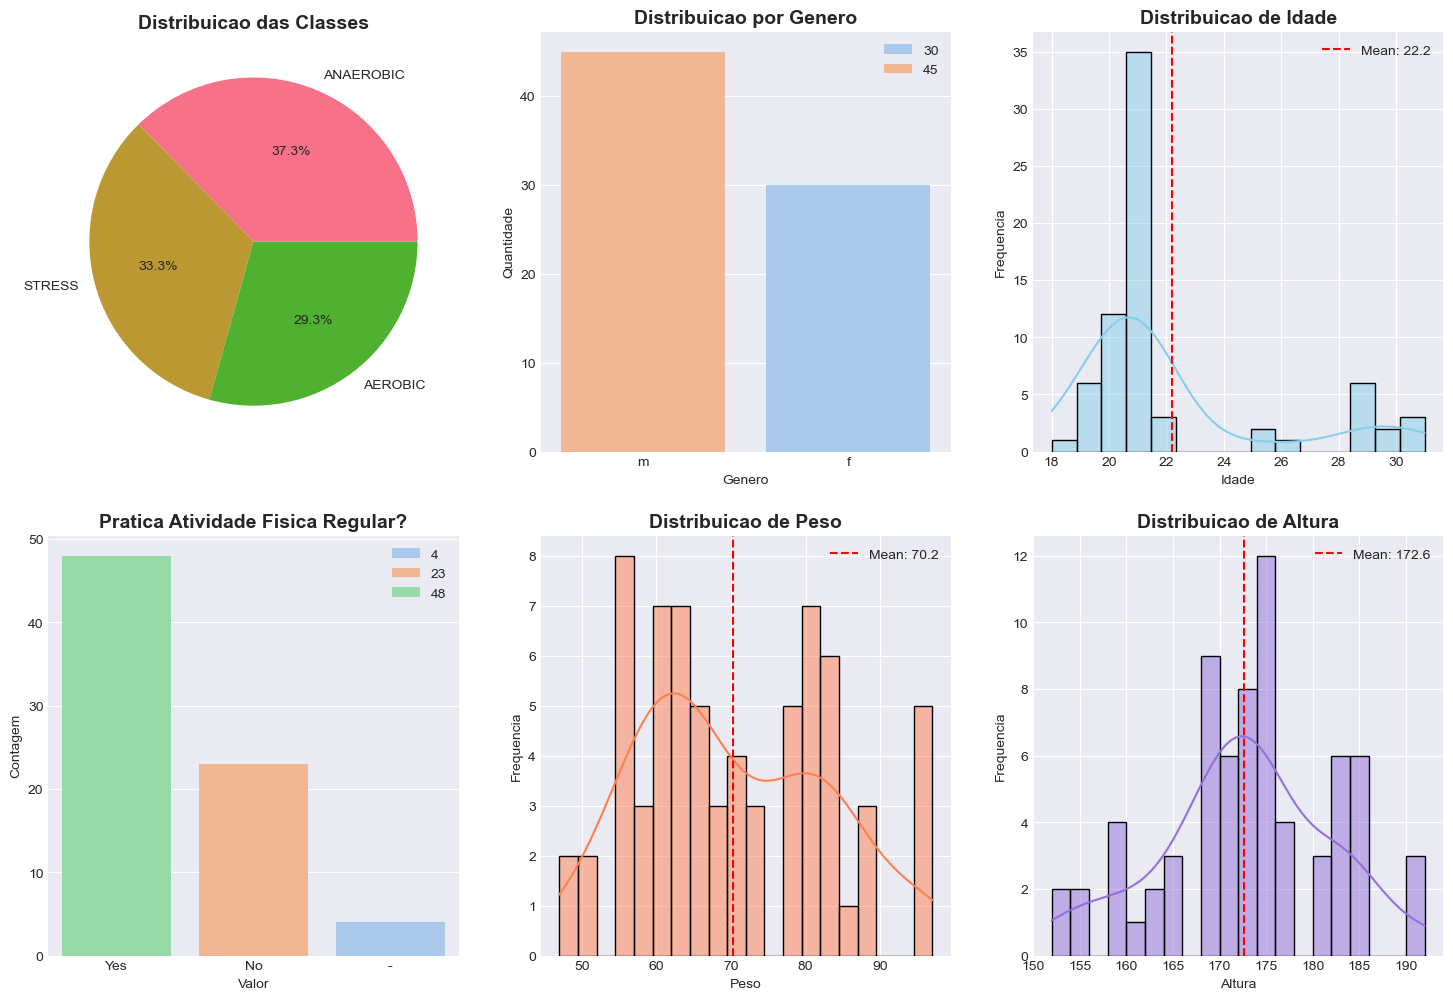

In [4]:
plot_distribuicoes_basicas(train_df)

Na distribuição da feature "Does physical activity regularly?" é mostrado que valores nulos são representados pelo caractere '-'. Dessa forma, precisaremos tratar esses dados no futuro.

### Análise de Distribuição dos Sensores

Agora, utilizaremos boxplots para visualizar a distribuição das features extraídas em cada sensor. 

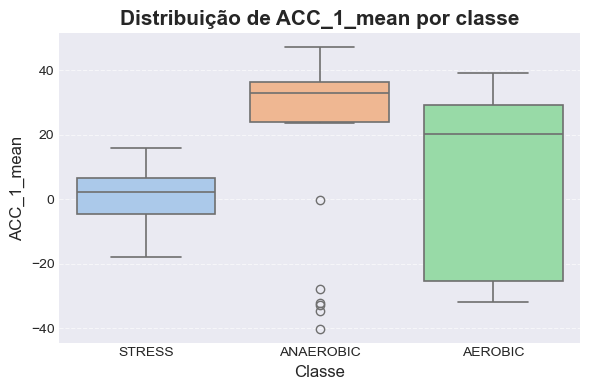

In [5]:
boxplot_sensor(train_df, col='ACC_1_mean')

Neste primeiro caso, já podemos notar que o sensor acelerômetro é sensível à direção do movimento do usuário. No nosso contexto, podemos ignorar a direção e trabalhar apenas com a intensidade do movimento.

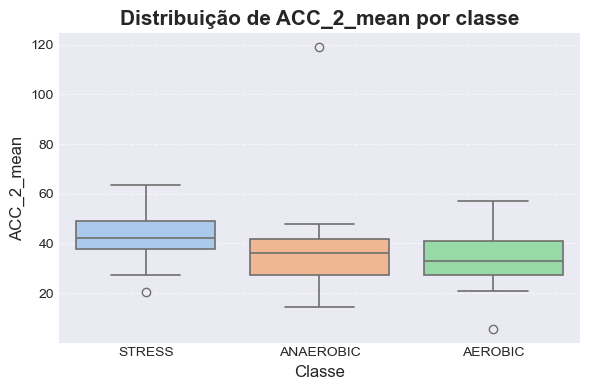

In [6]:
boxplot_sensor(train_df, col='ACC_2_mean')

No terceiro eixo podemos notar um valor completamente fora do esperado. A seguir, vamos identificar qual é esse usuário.

In [7]:
user_outlier = train_df[train_df['ACC_2_mean'] > 100]['Id'].values[0]
print(f'Usuário outlier identificado: {user_outlier}')

Usuário outlier identificado: U_92575


Ao abrir os dados do usuário com outlier, é identificado que o valor do terceiro eixo ficou congelado em '127.0' ao longo da maior parte da captura. Por isso trataremos esse caso no futuro.

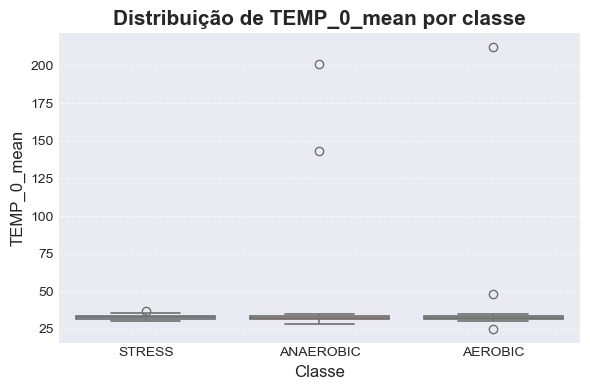

In [8]:
boxplot_sensor(train_df, col='TEMP_0_mean')

No sensor de temperatura da pele, também é encontrado 3 outliers.

In [9]:
# pega ids de quem tem temp acima de 100
high_temp_ids = train_df[train_df['TEMP_0_mean'] > 100]['Id'].unique()
display(high_temp_ids)

array(['U_60647', 'U_46045', 'U_20314'], dtype=object)

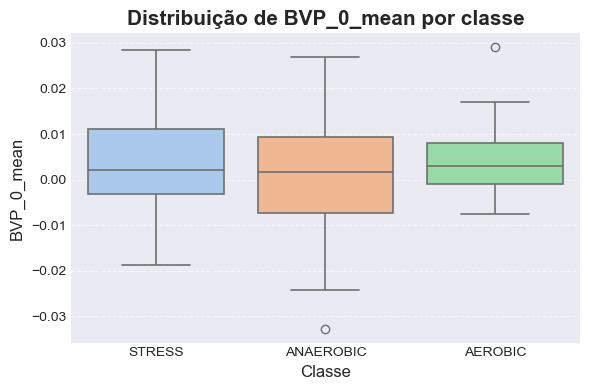

In [10]:
boxplot_sensor(train_df, col='BVP_0_mean')

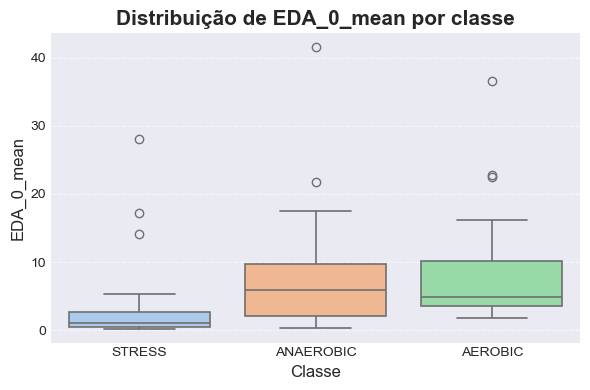

In [11]:
boxplot_sensor(train_df, col='EDA_0_mean')

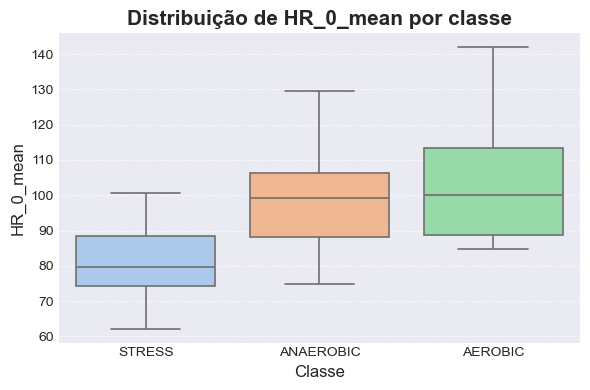

In [12]:
boxplot_sensor(train_df, col='HR_0_mean')

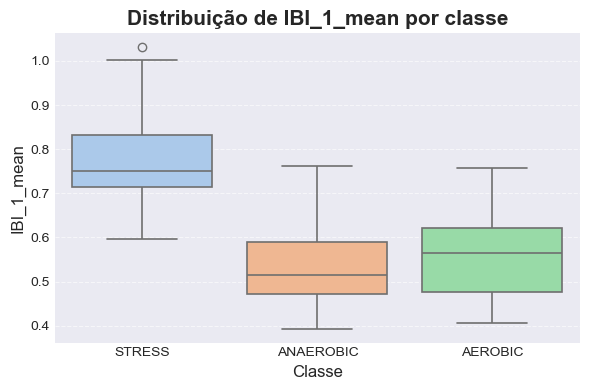

In [13]:
boxplot_sensor(train_df, col='IBI_1_mean')

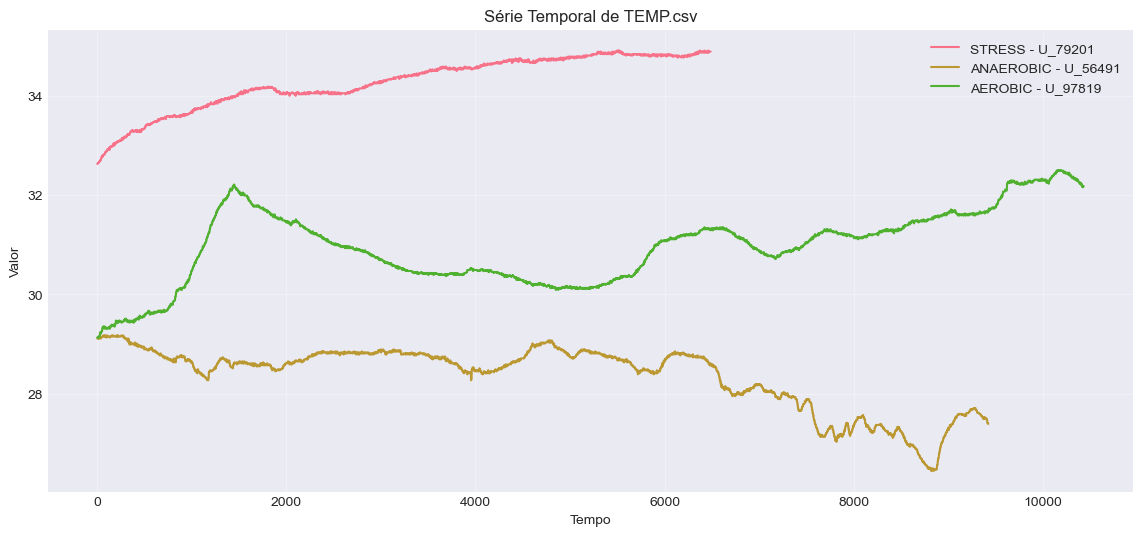

In [14]:
plot_sensor_by_label(train_df, BASE_PATH, dataLoader, sensor_name='TEMP.csv', samples_per_class=1)

---
### Pré-processamento

Nesta seção, as funções da etapa de pré-processamento dos dados devem ser implementadas e aplicadas (se necessário).

Vamos começar removendo os valores de temperatura daqueles usuários que possuem outlier.

In [15]:
## REMOÇÃO DE VALORES ALTOS NA TEMPERATURA DA PELE

high_temp_ids = train_df[train_df['TEMP_0_mean'] > 100]['Id'].unique()
train_df.loc[train_df['Id'].isin(high_temp_ids), train_df.columns.str.startswith('TEMP')] = np.nan

high_temp_ids = test_df[test_df['TEMP_0_mean'] > 100]['Id'].unique()
test_df.loc[test_df['Id'].isin(high_temp_ids), test_df.columns.str.startswith('TEMP')] = np.nan

A seguir, vamos processar os dados do ACC para calcular a magnitude.

In [16]:
## PROCESSAMENTO DOS DADOS DO ACELEROMETRO
## mais informações na documentação da função process_ACC

train_df = dataLoader.process_ACC(train_df, process_axis=True)
test_df = dataLoader.process_ACC(test_df, process_axis=True)

Transforma os valores '-' em NaN

In [17]:
## Substituição de valores '-' por NaN, em seguida trataremos os NaNs

train_df = train_df.replace('-', np.nan)
test_df = test_df.replace('-', np.nan)

In [18]:
## Podemos ver quando dados faltantes existem no dataset

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 41 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Id                                 75 non-null     object 
 1   Label                              75 non-null     object 
 2   BVP_0_mean                         75 non-null     float64
 3   BVP_0_std                          75 non-null     float64
 4   BVP_0_min                          75 non-null     float64
 5   BVP_0_max                          75 non-null     float64
 6   BVP_0_median                       75 non-null     float64
 7   EDA_0_mean                         75 non-null     float64
 8   EDA_0_std                          75 non-null     float64
 9   EDA_0_min                          75 non-null     float64
 10  EDA_0_max                          75 non-null     float64
 11  EDA_0_median                       75 non-null     float64
 

Agora vamos codificar os dados categóricos e lidar com os valores nulos do conjunto de dados.

In [19]:
## Aplicar codificação dos dados categóricos e imputação dos valores faltantes
## mais informações na documentação da função encoder_imputer

X, Y, test_df, le_target = encoder_imputer(train_df, test_df)

---
### Experimento

Nesta seção, o experimento deve ser conduzido, utilizando os protocolos experimentais padrões e testando diferentes modelos.

In [20]:
## Dividir dados em treino e validação na intenção de avaliar modelos posteriormente

X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

### k-vizinhos mais próximos

In [21]:
param_grid_knn = {
    'knn__n_neighbors': [7, 9, 11, 15, 20, 25, 30],    
    'knn__p': [1, 2],               
}

eval_dict = {}
eval_dict['knn'] = {}
eval_dict['knn']['acc'] = []
eval_dict['knn']['auc'] = []
eval_dict['knn']['name'] = []

grid_knn = fit_kfold_grid_search('knn', KNeighborsClassifier(), param_grid_knn, X_train, Y_train, use_scaler=True, use_pca=False)
grid_knn_pca = fit_kfold_grid_search('knn', KNeighborsClassifier(), param_grid_knn, X_train, Y_train, use_scaler=True, use_pca=True)

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 14 candidates, totalling 42 fits


In [22]:
grid_knn.fit(X_train, Y_train)
print(f"\nMelhores parâmetros: {grid_knn.best_params_}\n")
best_model_knn = grid_knn.best_estimator_

y_val_pred_proba_knn = best_model_knn.predict_proba(X_val)
roc_auc_knn = roc_auc_score(pd.get_dummies(Y_val), y_val_pred_proba_knn, multi_class='ovr')
print(f"AUC final no conjunto de validação: {roc_auc_knn:.4f}")

y_val_pred_knn = best_model_knn.predict(X_val)
acc_knn = accuracy_score(Y_val, y_val_pred_knn)
print(f"Acurácia no conjunto de validação: {acc_knn:.4f}")

eval_dict['knn']['auc'].append(roc_auc_knn)
eval_dict['knn']['acc'].append(acc_knn)
eval_dict['knn']['name'].append('KNN sem PCA')

Fitting 3 folds for each of 14 candidates, totalling 42 fits

Melhores parâmetros: {'knn__n_neighbors': 9, 'knn__p': 1}

AUC final no conjunto de validação: 0.8146
Acurácia no conjunto de validação: 0.6667


In [23]:
grid_knn_pca.fit(X_train, Y_train)
print(f"\nMelhores parâmetros: {grid_knn_pca.best_params_}\n")
best_model_knn_pca = grid_knn_pca.best_estimator_

y_val_pred_proba_knn_pca = best_model_knn_pca.predict_proba(X_val)
roc_auc_knn_pca = roc_auc_score(pd.get_dummies(Y_val), y_val_pred_proba_knn_pca, multi_class='ovr')
print(f"AUC final no conjunto de validação: {roc_auc_knn_pca:.4f}")

y_val_pred_knn_pca = best_model_knn_pca.predict(X_val)
acc_knn_pca = accuracy_score(Y_val, y_val_pred_knn_pca)
print(f"Acurácia no conjunto de validação: {acc_knn_pca:.4f}")

eval_dict['knn']['auc'].append(roc_auc_knn_pca)
eval_dict['knn']['acc'].append(acc_knn_pca)
eval_dict['knn']['name'].append('KNN com PCA')

Fitting 3 folds for each of 14 candidates, totalling 42 fits

Melhores parâmetros: {'knn__n_neighbors': 20, 'knn__p': 2}

AUC final no conjunto de validação: 0.7253
Acurácia no conjunto de validação: 0.6000


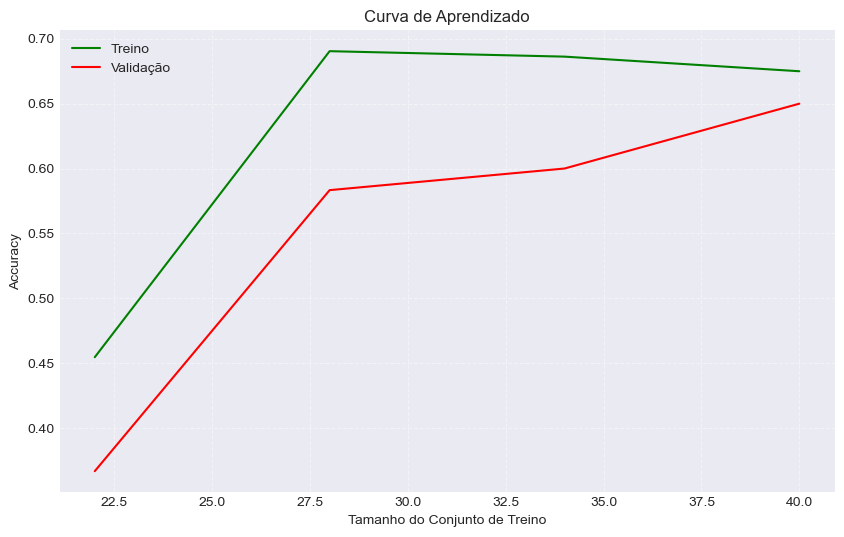

In [24]:
plot_learning_curve(best_model_knn_pca, X_train, Y_train, scoring="accuracy")

Surpreendentemente, o método KNN obteve uma pontuação maior quando não foi utilizado o PCA para a redução da dimensionalidade, apesar da alta dimensionalidade dos dados.

### Naive Bayes

In [25]:
param_grid_nb = {
    'nb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]                      
}

eval_dict['nb'] = {}
eval_dict['nb']['acc'] = []
eval_dict['nb']['auc'] = []
eval_dict['nb']['name'] = []

grid_nb_pca = fit_kfold_grid_search('nb', GaussianNB(), param_grid_nb, X_train, Y_train, use_scaler=True, use_pca=True)
grid_nb = fit_kfold_grid_search('nb', GaussianNB(), param_grid_nb, X_train, Y_train, use_scaler=True, use_pca=False)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [26]:
grid_nb_pca.fit(X_train, Y_train)
print(f"\nMelhores parâmetros: {grid_nb_pca.best_params_}\n")
best_model_nb_pca = grid_nb_pca.best_estimator_

y_val_pred_proba_nb_pca = best_model_nb_pca.predict_proba(X_val)
roc_auc_nb_pca = roc_auc_score(pd.get_dummies(Y_val), y_val_pred_proba_nb_pca, multi_class='ovr')
print(f"AUC final no conjunto de validação: {roc_auc_nb_pca:.4f}")

y_val_pred_nb_pca = best_model_nb_pca.predict(X_val)
acc_nb_pca = accuracy_score(Y_val, y_val_pred_nb_pca)
print(f"Acurácia no conjunto de validação: {acc_nb_pca:.4f}")

eval_dict['nb']['auc'].append(roc_auc_nb_pca)
eval_dict['nb']['acc'].append(acc_nb_pca)
eval_dict['nb']['name'].append('Naive Bayes com PCA')

Fitting 3 folds for each of 5 candidates, totalling 15 fits

Melhores parâmetros: {'nb__var_smoothing': 1e-09}

AUC final no conjunto de validação: 0.6737
Acurácia no conjunto de validação: 0.4667


In [27]:
grid_nb.fit(X_train, Y_train)
print(f"\nMelhores parâmetros: {grid_nb.best_params_}\n")
best_model_nb = grid_nb.best_estimator_

y_val_pred_proba_nb = best_model_nb.predict_proba(X_val)
roc_auc_nb = roc_auc_score(pd.get_dummies(Y_val), y_val_pred_proba_nb, multi_class='ovr')
print(f"AUC final no conjunto de validação: {roc_auc_nb:.4f}")

y_val_pred_nb = best_model_nb.predict(X_val)
acc_nb = accuracy_score(Y_val, y_val_pred_nb)
print(f"Acurácia no conjunto de validação: {acc_nb:.4f}")

eval_dict['nb']['auc'].append(roc_auc_nb)
eval_dict['nb']['acc'].append(acc_nb)
eval_dict['nb']['name'].append('Naive Bayes')

Fitting 3 folds for each of 5 candidates, totalling 15 fits

Melhores parâmetros: {'nb__var_smoothing': 1e-06}

AUC final no conjunto de validação: 0.5937
Acurácia no conjunto de validação: 0.5333


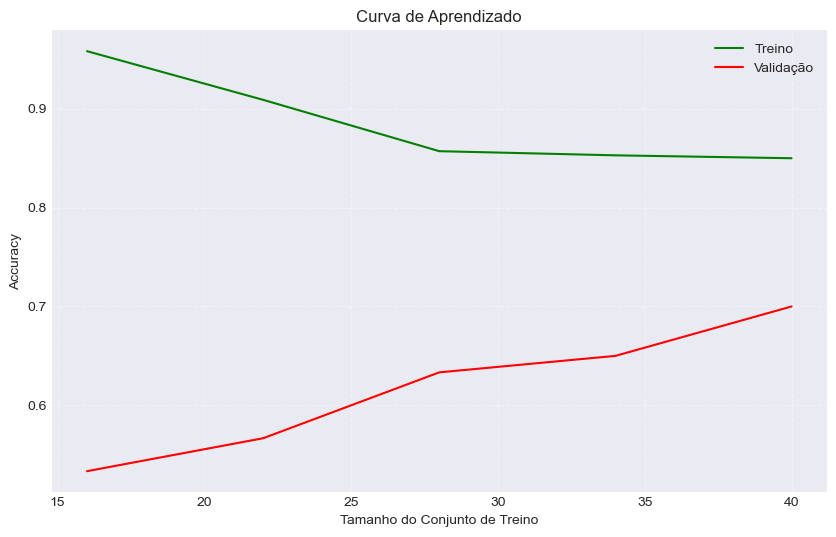

In [28]:
plot_learning_curve(best_model_nb, X_train, Y_train, scoring="accuracy")

### Regressão Logística

In [29]:
param_grid_lr = {
    'LogReg__C': [0.01, 0.1, 1, 10, 100],
    'LogReg__penalty': ['l2'],
    'LogReg__solver': ['lbfgs']  
}

eval_dict['lr'] = {}
eval_dict['lr']['acc'] = []
eval_dict['lr']['auc'] = []
eval_dict['lr']['name'] = []

grid_lr = fit_kfold_grid_search('LogReg', LogisticRegression(), param_grid_lr, X_train, Y_train, use_scaler=True, use_pca=False)
grid_lr_pca = fit_kfold_grid_search('LogReg', LogisticRegression(), param_grid_lr, X_train, Y_train, use_scaler=True, use_pca=True)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [30]:
grid_lr.fit(X_train, Y_train)
print(f"\nMelhores parâmetros: {grid_lr.best_params_}\n")
best_model_lr = grid_lr.best_estimator_

y_val_pred_proba_lr = best_model_lr.predict_proba(X_val)
roc_auc_lr = roc_auc_score(pd.get_dummies(Y_val), y_val_pred_proba_lr, multi_class='ovr')
print(f"AUC final no conjunto de validação: {roc_auc_lr:.4f}")

y_val_pred_lr = best_model_lr.predict(X_val)
acc_lr = accuracy_score(Y_val, y_val_pred_lr)
print(f"Acurácia no conjunto de validação: {acc_lr:.4f}")

eval_dict['lr']['auc'].append(roc_auc_lr)
eval_dict['lr']['acc'].append(acc_lr)
eval_dict['lr']['name'].append('Regressão Logística')

Fitting 3 folds for each of 5 candidates, totalling 15 fits

Melhores parâmetros: {'LogReg__C': 0.01, 'LogReg__penalty': 'l2', 'LogReg__solver': 'lbfgs'}

AUC final no conjunto de validação: 0.7663
Acurácia no conjunto de validação: 0.6667


In [31]:
grid_lr_pca.fit(X_train, Y_train)
print(f"\nMelhores parâmetros: {grid_lr_pca.best_params_}\n")
best_model_lr_pca = grid_lr_pca.best_estimator_

y_val_pred_proba_lr_pca = best_model_lr_pca.predict_proba(X_val)
roc_auc_lr_pca = roc_auc_score(pd.get_dummies(Y_val), y_val_pred_proba_lr_pca, multi_class='ovr')
print(f"AUC final no conjunto de validação: {roc_auc_lr_pca:.4f}")

y_val_pred_lr_pca = best_model_lr_pca.predict(X_val)
acc_lr_pca = accuracy_score(Y_val, y_val_pred_lr_pca)
print(f"Acurácia no conjunto de validação: {acc_lr_pca:.4f}")

eval_dict['lr']['auc'].append(roc_auc_lr_pca)
eval_dict['lr']['acc'].append(acc_lr_pca)
eval_dict['lr']['name'].append('Regressão Logística com PCA')

Fitting 3 folds for each of 5 candidates, totalling 15 fits

Melhores parâmetros: {'LogReg__C': 0.1, 'LogReg__penalty': 'l2', 'LogReg__solver': 'lbfgs'}

AUC final no conjunto de validação: 0.7156
Acurácia no conjunto de validação: 0.5333


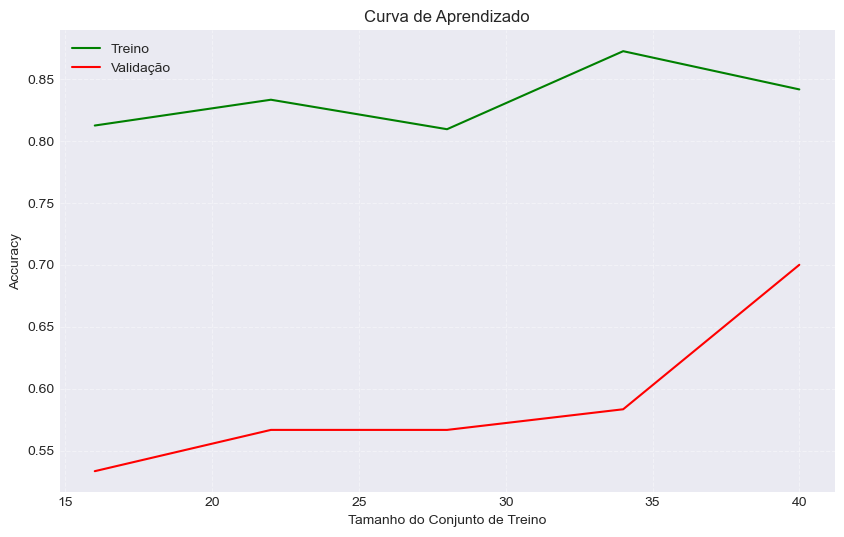

In [32]:
plot_learning_curve(best_model_lr, X_train, Y_train, scoring="accuracy")

#### Redes Neurais Artificiais

In [33]:
param_grid_mlp = {
    'MLP__activation': ['relu', 'tanh'],
    'MLP__solver': ['adam', 'sgd'],
    'MLP__alpha': [0.01, 0.1, 1],
    'MLP__hidden_layer_sizes': [(50,), (100,), (50,50)]
}

eval_dict['mlp'] = {}
eval_dict['mlp']['acc'] = []
eval_dict['mlp']['auc'] = []
eval_dict['mlp']['name'] = []

grid_mlp = fit_kfold_grid_search('MLP', MLPClassifier(), param_grid_mlp, X_train, Y_train, use_scaler=True, use_pca=False)
grid_mlp_pca = fit_kfold_grid_search('MLP', MLPClassifier(), param_grid_mlp, X_train, Y_train, use_scaler=True, use_pca=True)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


d:\Programas\Anaconda\envs\ia_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 3 folds for each of 36 candidates, totalling 108 fits


d:\Programas\Anaconda\envs\ia_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [34]:
grid_mlp.fit(X_train, Y_train)
print(f"\nMelhores parâmetros: {grid_mlp.best_params_}\n")
best_model_mlp = grid_mlp.best_estimator_

y_val_pred_proba_mlp = best_model_mlp.predict_proba(X_val)
roc_auc_mlp = roc_auc_score(pd.get_dummies(Y_val), y_val_pred_proba_mlp, multi_class='ovr')
print(f"AUC final no conjunto de validação: {roc_auc_mlp:.4f}")

y_val_pred_mlp = best_model_mlp.predict(X_val)
acc_mlp = accuracy_score(Y_val, y_val_pred_mlp)
print(f"Acurácia no conjunto de validação: {acc_mlp:.4f}")

eval_dict['mlp']['auc'].append(roc_auc_mlp)
eval_dict['mlp']['acc'].append(acc_mlp)
eval_dict['mlp']['name'].append('Rede Neural')

Fitting 3 folds for each of 36 candidates, totalling 108 fits

Melhores parâmetros: {'MLP__activation': 'tanh', 'MLP__alpha': 0.01, 'MLP__hidden_layer_sizes': (50, 50), 'MLP__solver': 'sgd'}

AUC final no conjunto de validação: 0.7738
Acurácia no conjunto de validação: 0.6667


d:\Programas\Anaconda\envs\ia_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [35]:
grid_mlp_pca.fit(X_train, Y_train)
print(f"\nMelhores parâmetros: {grid_mlp_pca.best_params_}\n")
best_model_mlp_pca = grid_mlp_pca.best_estimator_

y_val_pred_proba_mlp_pca = best_model_mlp_pca.predict_proba(X_val)
roc_auc_mlp_pca = roc_auc_score(pd.get_dummies(Y_val), y_val_pred_proba_mlp_pca, multi_class='ovr')
print(f"AUC final no conjunto de validação: {roc_auc_mlp_pca:.4f}")

y_val_pred_mlp_pca = best_model_mlp_pca.predict(X_val)
acc_mlp_pca = accuracy_score(Y_val, y_val_pred_mlp_pca)
print(f"Acurácia no conjunto de validação: {acc_mlp_pca:.4f}")

eval_dict['mlp']['auc'].append(roc_auc_mlp_pca)
eval_dict['mlp']['acc'].append(acc_mlp_pca)
eval_dict['mlp']['name'].append('Rede Neural com PCA')

Fitting 3 folds for each of 36 candidates, totalling 108 fits

Melhores parâmetros: {'MLP__activation': 'tanh', 'MLP__alpha': 0.1, 'MLP__hidden_layer_sizes': (50,), 'MLP__solver': 'sgd'}

AUC final no conjunto de validação: 0.6734
Acurácia no conjunto de validação: 0.5333


d:\Programas\Anaconda\envs\ia_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


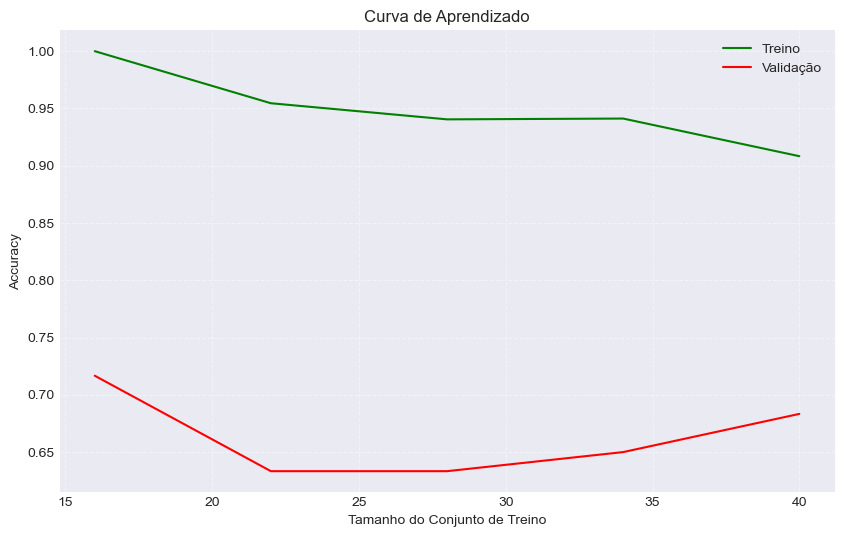

In [36]:
plot_learning_curve(best_model_mlp_pca, X_train, Y_train, scoring="accuracy")

### SVM

In [37]:
param_grid_svm = {
    'svm__kernel': ['rbf'],          
    'svm__C': [0.1, 1, 10, 100],     
    'svm__gamma': ['scale', 0.1, 0.01, 0.001] 
}

eval_dict['svm'] = {}
eval_dict['svm']['acc'] = []
eval_dict['svm']['auc'] = []
eval_dict['svm']['name'] = []

grid_svm = fit_kfold_grid_search('svm', SVC(probability=True, random_state=42), param_grid_svm, X_train, Y_train, use_scaler=True)
grid_svm_pca = fit_kfold_grid_search('svm', SVC(probability=True, random_state=42), param_grid_svm, X_train, Y_train, use_scaler=True, use_pca=True)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [38]:
grid_svm.fit(X_train, Y_train)
print(f"\nMelhores parâmetros: {grid_svm.best_params_}\n")

best_model_svm = grid_svm.best_estimator_
y_val_pred_proba_svm = best_model_svm.predict_proba(X_val)
roc_auc_svm = roc_auc_score(pd.get_dummies(Y_val), y_val_pred_proba_svm, multi_class='ovr')
print(f"AUC final no conjunto de validação: {roc_auc_svm:.4f}")

y_val_pred_svm = best_model_svm.predict(X_val)
acc_svm = accuracy_score(Y_val, y_val_pred_svm)
print(f"Acurácia no conjunto de validação: {acc_svm:.4f}")

eval_dict['svm']['auc'].append(roc_auc_svm)
eval_dict['svm']['acc'].append(acc_svm)
eval_dict['svm']['name'].append('SVM')

Fitting 3 folds for each of 16 candidates, totalling 48 fits

Melhores parâmetros: {'svm__C': 10, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}

AUC final no conjunto de validação: 0.8185
Acurácia no conjunto de validação: 0.6000


In [39]:
grid_svm_pca.fit(X_train, Y_train)
print(f"\nMelhores parâmetros: {grid_svm_pca.best_params_}\n")

best_model_svm_pca = grid_svm_pca.best_estimator_
y_val_pred_proba_svm_pca = best_model_svm_pca.predict_proba(X_val)
roc_auc_svm_pca = roc_auc_score(pd.get_dummies(Y_val), y_val_pred_proba_svm_pca, multi_class='ovr')
print(f"AUC final no conjunto de validação: {roc_auc_svm_pca:.4f}")

y_val_pred_svm_pca = best_model_svm_pca.predict(X_val)
acc_svm_pca = accuracy_score(Y_val, y_val_pred_svm_pca)
print(f"Acurácia no conjunto de validação: {acc_svm_pca:.4f}")

eval_dict['svm']['auc'].append(roc_auc_svm_pca)
eval_dict['svm']['acc'].append(acc_svm_pca)
eval_dict['svm']['name'].append('SVM com PCA')

Fitting 3 folds for each of 16 candidates, totalling 48 fits

Melhores parâmetros: {'svm__C': 100, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}

AUC final no conjunto de validação: 0.7910
Acurácia no conjunto de validação: 0.5333


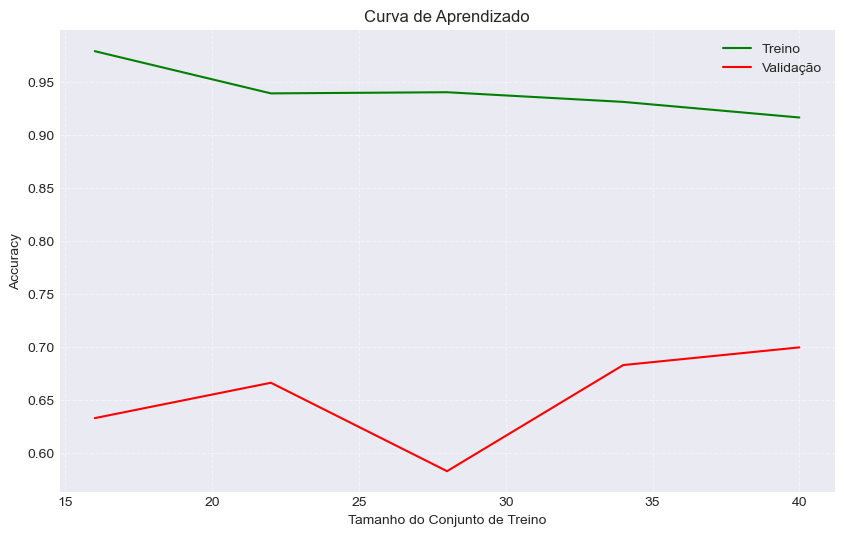

In [40]:
plot_learning_curve(best_model_svm_pca, X_train, Y_train, scoring="accuracy")

### XGBoost


In [41]:
param_grid = {
    'xgb__n_estimators': [20, 25, 50, 100],     
    'xgb__max_depth': [2, 3, 4],            
    'xgb__learning_rate': [0.02, 0.05],      
    'xgb__subsample': [0.8],                 
    'xgb__colsample_bytree': [0.8],    
    'xgb__reg_lambda': [1, 2, 3],
    'xgb__reg_alpha': [0.5, 1],
}


grid = fit_kfold_grid_search('xgb', XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1, verbosity=0), param_grid, X_train, Y_train, use_scaler=False, use_pca=False, error_score=0.5)
grid_pca = fit_kfold_grid_search('xgb', XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1, verbosity=0), param_grid, X_train, Y_train, use_scaler=False, use_pca=True, error_score=0.5)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Fitting 3 folds for each of 144 candidates, totalling 432 fits


In [42]:
grid.fit(X_train, Y_train)
print(f"\nMelhores parâmetros: {grid.best_params_}\n")
best_model = grid.best_estimator_

y_val_pred_proba = best_model.predict_proba(X_val)
roc_auc = roc_auc_score(pd.get_dummies(Y_val), y_val_pred_proba, multi_class='ovr')
print(f"AUC final no conjunto de validação: {roc_auc:.4f}")

y_val_pred = best_model.predict(X_val)
acc = accuracy_score(Y_val, y_val_pred)
print(f"Acurácia no conjunto de validação: {acc:.4f}")

Fitting 3 folds for each of 144 candidates, totalling 432 fits

Melhores parâmetros: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.02, 'xgb__max_depth': 2, 'xgb__n_estimators': 20, 'xgb__reg_alpha': 0.5, 'xgb__reg_lambda': 1, 'xgb__subsample': 0.8}

AUC final no conjunto de validação: 0.9791
Acurácia no conjunto de validação: 0.8000


In [43]:
# Avaliando no treino (para conferência de Overfitting)
y_train_pred_proba = best_model.predict_proba(X_train)
roc_auc_train = roc_auc_score(pd.get_dummies(Y_train), y_train_pred_proba, multi_class='ovr')

print(f"AUC Treino: {roc_auc_train:.4f}")
print(f"AUC Validação: {roc_auc:.4f}")
print(f"Diferença (Gap): {roc_auc_train - roc_auc:.4f}")

AUC Treino: 0.9838
AUC Validação: 0.9791
Diferença (Gap): 0.0047


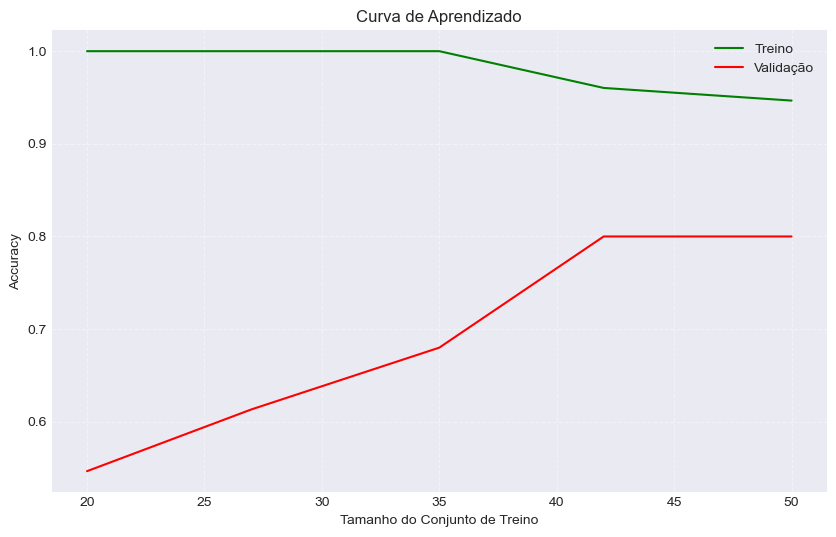

In [44]:
plot_learning_curve(best_model, X, Y, scoring="accuracy")

## Modelo ganancioso

Agora vamos treinar um modelo XGBoost sem medo de ter overfit. 

In [45]:
model_ganancioso = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,  
    num_class=3,                 
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
model_ganancioso.fit(X_train, Y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [46]:
y_val_pred_proba = model_ganancioso.predict_proba(X_val)
roc_auc = roc_auc_score(pd.get_dummies(Y_val), y_val_pred_proba, multi_class='ovr')
print(f"AUC final no conjunto de validação: {roc_auc:.4f}")

AUC final no conjunto de validação: 0.9663


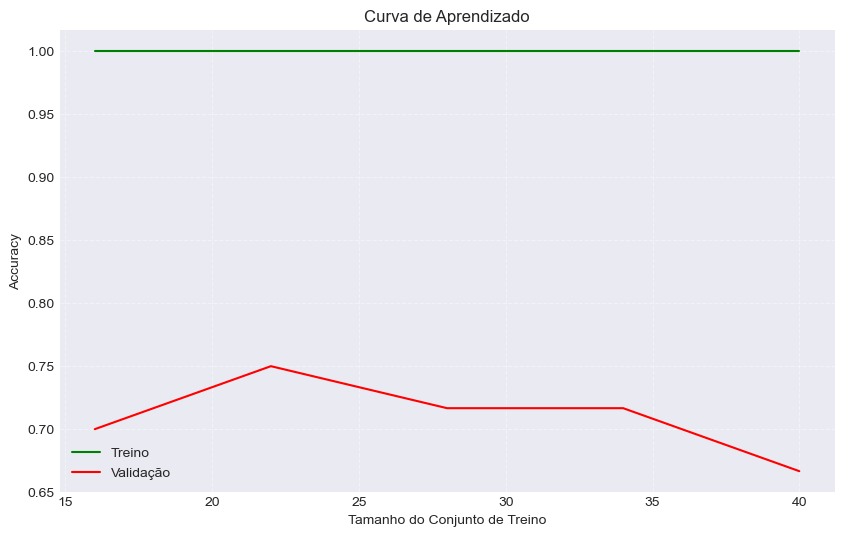

In [47]:
plot_learning_curve(model_ganancioso, X_train, Y_train, scoring="accuracy")

Apesar de um claro overfit, esse modelo em questão obteve score 1.00000 no ranking público do Kaggle. 

---
### Análise dos Resultados

Nesta seção, os resultados devem ser exibidos através de tabelas e gráficos, comparados e profundamente analisados.

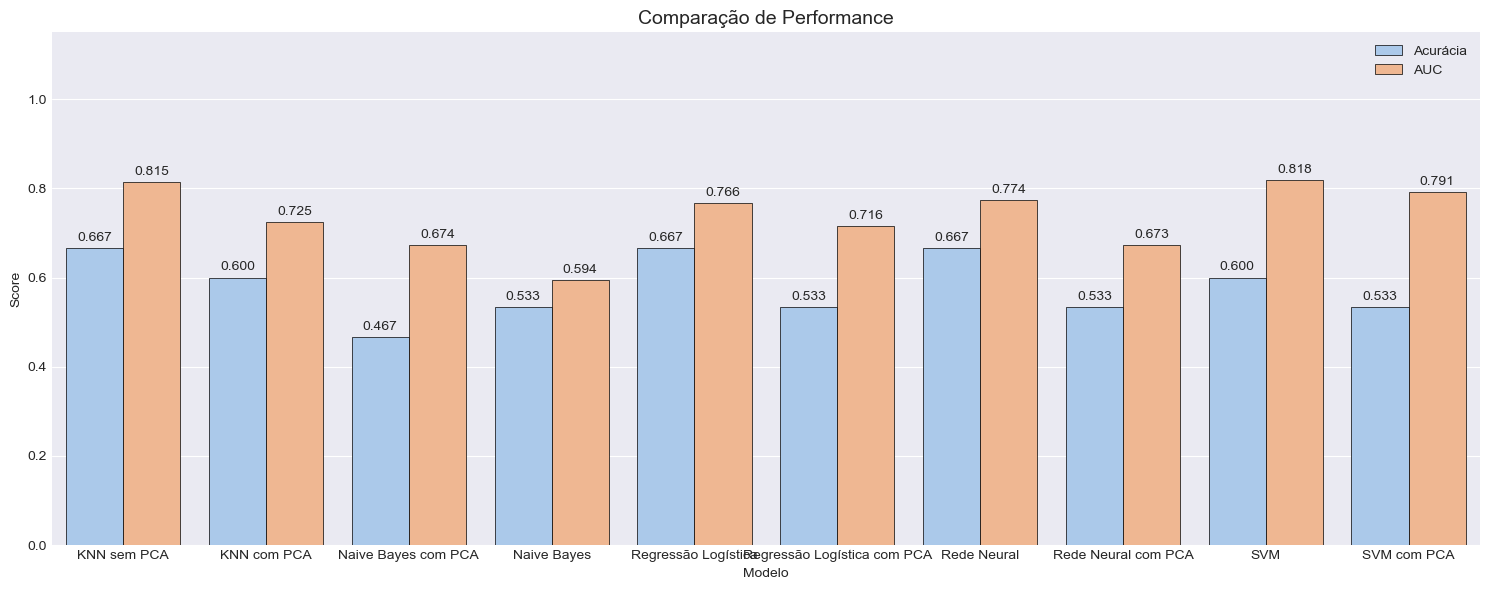

In [48]:
plot_metrics(eval_dict)

A partir do gráfico é possível notar que, apesar da alta dimensionalidade dos dados, a aplicação do PCA piorou a performance em praticamente todos os casos (Com exceção do Naive Bayes).

Os melhores modelos foram o SVM e o KNN sem a aplicação de PCA.
* **SVM**: Melhor AUC (0.818).
* **KNN**: Maior acurácia empatada (0.667) e segunda melhor AUC (0.815).  

Com isso, é entendido que para este conjunto específico de features, a redução de dimensionalidade está atrapalhando e devemos trabalhar com as features originais.
Ademais, entre esses modelos o maior potencial é o KNN por ter uma pontuação AUC praticamente igual ao do SVM que ficou em primeiro e ter uma acurácia superior. Entretanto, nenhum desses modelos conseguem chegar nem perto de atingir o resultado do método baseado em Gradient Boosting.


In [49]:
## Vamos criar o modelo feito no gridsearch como um objeto separado do xgboost

best_params = grid.best_params_
clean_params = {k.replace('xgb__', ''): v for k, v in best_params.items()}
model_xgb = XGBClassifier(**clean_params, random_state=42, n_jobs=-1)
model_xgb.fit(X_train, Y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


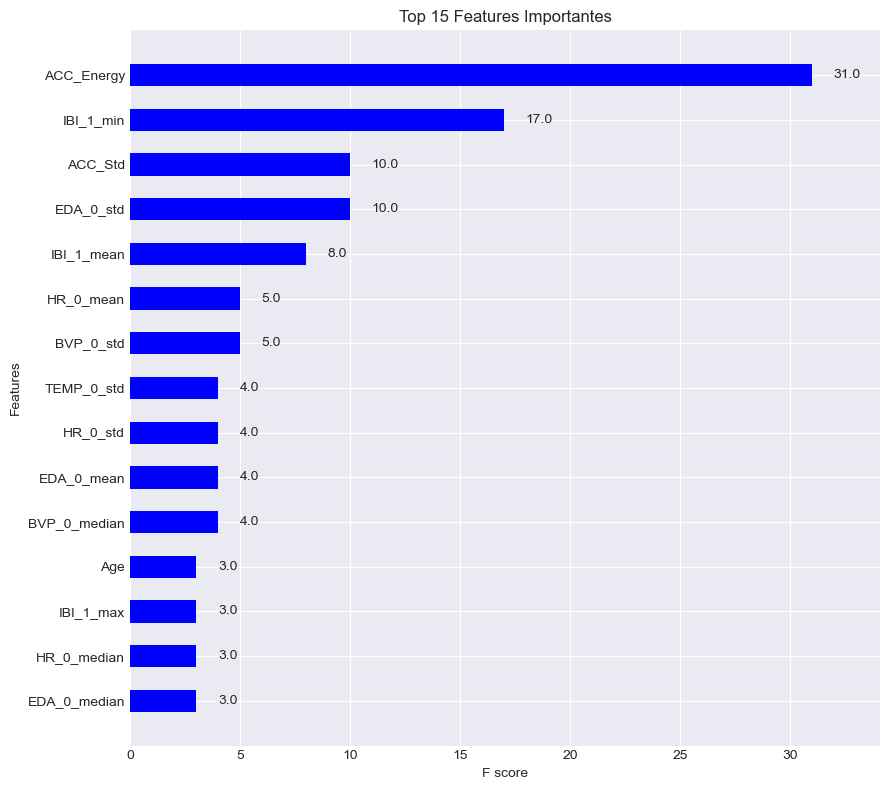

In [50]:
plot_feature_importance_comparison(model_xgb)

Com o XGBoost é possível visualizar a importância de cada feature para a tomada de decisão do modelo. É notado que o atributo mais importante foi o ACC_Energy: o somatório do quadrados dos valores do acelerômetro. Em seguida vem o mínimo do sensor IBI. O único valor de informação do usuário que apareceu no ranking foi a idade.

---
### Salvar melhor resultado



In [ ]:
model = best_model
X_test = test_df[X.columns] 
probs_test = model.predict_proba(X_test)


# é sempre bom dar uma olhada no numero das classes certinho antes de salvar a submissão  
# (#print(le_target.classes_))
submission = pd.DataFrame({
    "Id": test_df["Id"],
    "Predicted_0": probs_test[:, 2],
    "Predicted_1": probs_test[:, 0],
    "Predicted_2": probs_test[:, 1],
})

submission.to_csv("submission.csv", index=False)